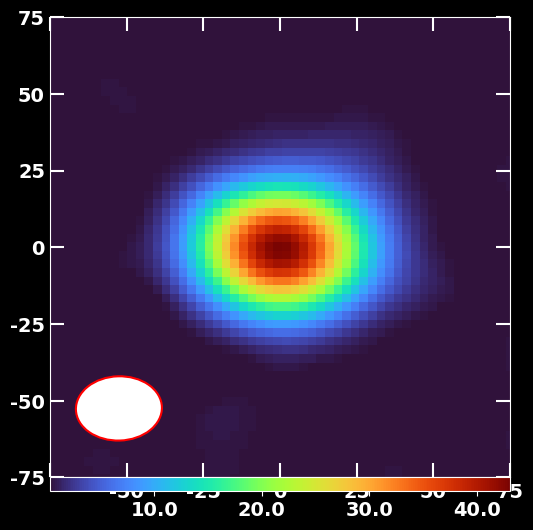

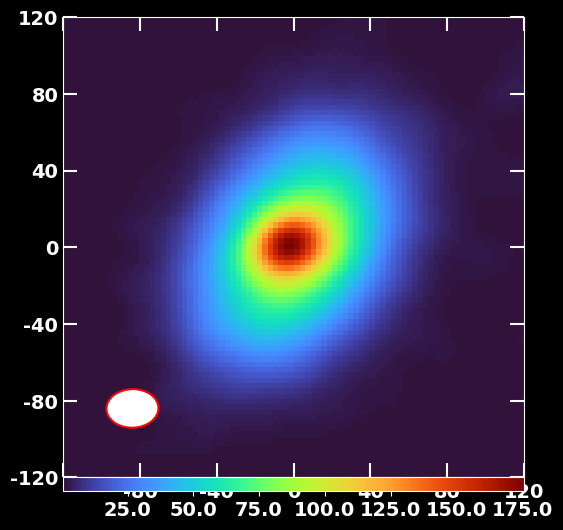

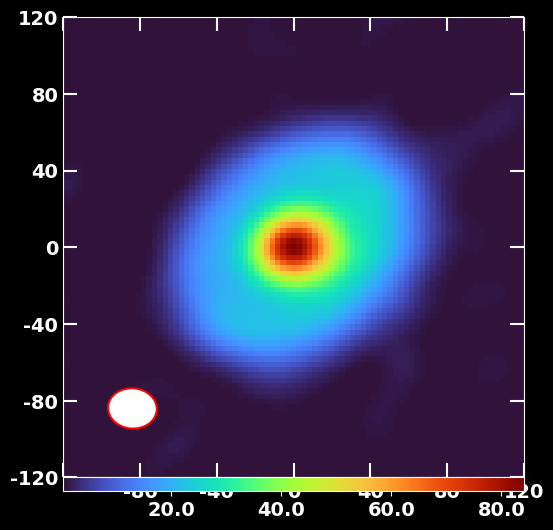

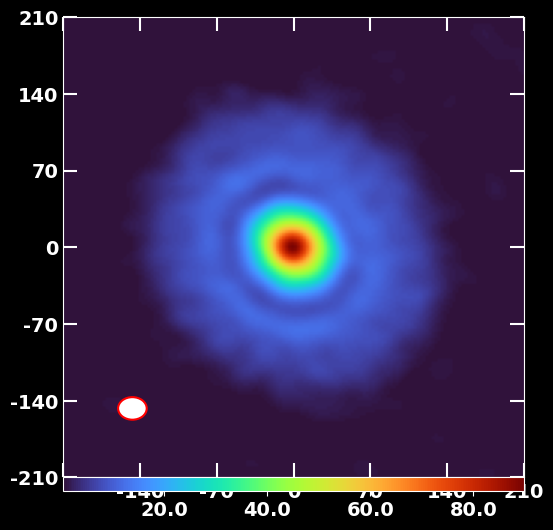

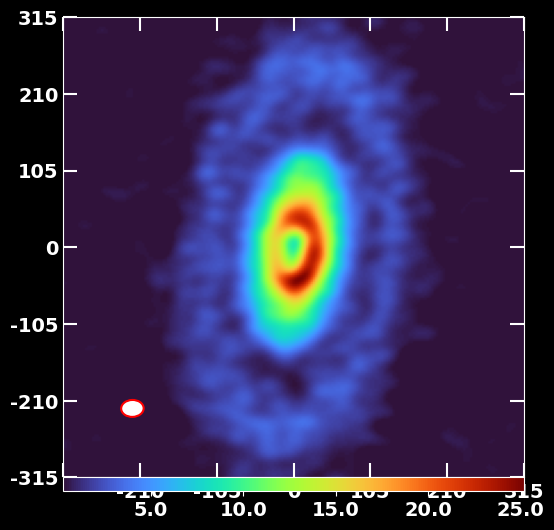

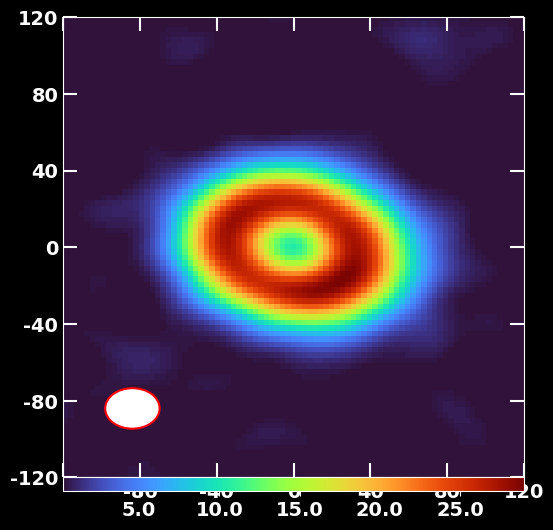

In [1]:
"""
Small script to generate a plot demonstrating the overall comparison of 
data and model in different proposed stage scenarios akin to Orcajo et al. 2025.
"""
# === Standard Library ===
from functools import wraps
import os
import time
import warnings
import logging

# === Third-Party ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from scipy import special
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.utils.exceptions import AstropyWarning

# === Internal ===

from bhowmik2025_et_al_plots.utils import (
    AddPatches,
    arc_to_au,
    FixTicks as ft,
    PathUtils,
)

warnings.simplefilter("ignore", category=AstropyWarning)
################################################################################

paths = PathUtils()

csv_features: str = (
    f"{paths.input_dir}/gap_ring_infl_pt.csv"  # <-- Your annotated features file
)
features_data = pd.read_csv(csv_features, index_col=False)
features_data["Target"] = features_data["Target"].astype(str).str.lower()
full_table = pd.read_csv(f"{paths.input_dir}/full_table.csv", index_col=False)

index_to_groups = full_table.groupby(by="id")["Group"].apply(func=list).to_dict()

ref_names_stages = {
    "ODISEA_C4_103": "Stage 0",
    "ODISEA_C4_130": "Stage 1",
    "ODISEA_C4_30": "Stage 2",
    "ODISEA_C4_41": "Stage 3",
    "ODISEA_C4_143": "Stage 4",
    "ODISEA_C4_141": "Stage 5",
}
ref_names = list(ref_names_stages.keys())

subset = full_table[full_table["field"].str.upper().isin(ref_names)].reset_index().sort_values(by="Stage")

zoom_factor = 1.0

for count, row in enumerate(subset.itertuples()):
    i = row.path
    j = row.path_model
    profile_file = row.path_rad
    name = row.field
    r_frank = row.Rmax_frank
    cen_x_sex = row.center_x
    cen_y_sex = row.center_y
    bpa = row.beam_pa
    bmaj = row.beam_maj
    bmin = row.beam_min
    dist = row.Distance
    b8_flux = row.B8_Flux
    disk_id = row.id
    isbinary = row.isbinary
    r_zoom = row.R_zoom
    rms_data = row.rms_data
    # rms_model = row.rms_model_profile
    coord = SkyCoord(
        ra=cen_x_sex,
        dec=cen_y_sex,
        unit=(u.hourangle, u.deg),
        frame="fk5",
        equinox="J2000.0",
    )
    with fits.open(i) as hdul_data, fits.open(j) as hdul_model:

        # Extracting header and data from the FITS files
        header_data = hdul_data[0].header
        data_data = hdul_data[0].data

        header_model = hdul_model[0].header
        data_model = hdul_model[0].data

    ########################################
    # Loading wcs
    pixel_scale_data: float = header_data["CDELT2"] * 3600  # in arcsec / pixel
    pixel_scale_model = r_frank * 2 / header_model["NAXIS1"]  # in arcsec / pixel
    wcs = WCS(header_data)

    # Defining centers
    center_ra_deg, center_dec_deg = coord.ra.deg, coord.dec.deg
    center_ra_pix, center_dec_pix = wcs.all_world2pix(
        center_ra_deg, center_dec_deg, 0
    )
    ########################################
    # Definying total boxsize and few more parameters
    # In case you want to apply a zoom factor manually

    imsize_radius_model_arcsec: float = r_zoom  # in arcsec
    imsize_model_pix: float = header_model["NAXIS1"]  # in pix
    imsize_radius_data_pix = imsize_radius_model_arcsec / pixel_scale_data  # in pix
    imsize_radius_model_pix = (
        imsize_radius_model_arcsec / pixel_scale_model
    )  # in pix

    boxsize_au = (
        np.round((imsize_radius_model_arcsec * 2) * arc_to_au(dist), -1)
        / zoom_factor
    )  # Value -1 corresponds to rounding to the nearest 10 au

    plt.style.use('dark_background')
    fig = plt.figure(figsize=(15, 5), layout="constrained")
        #################### AX0 - DATA #################################################

    ax0 = plt.subplot(131)

    im0 = ax0.imshow(
        X=data_data,
        origin="lower",
        cmap="turbo",
        aspect="equal",
        vmin=rms_data,
    )

    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_xticklabels([])
    ax0.set_yticklabels([])
    # ax0.set_facecolor("black")
    # Limits
    ax0.set_xlim(
        center_ra_pix - (imsize_radius_data_pix) / zoom_factor,
        center_ra_pix + (imsize_radius_data_pix) / zoom_factor,
    )
    ax0.set_ylim(
        center_dec_pix - (imsize_radius_data_pix) / zoom_factor,
        center_dec_pix + (imsize_radius_data_pix) / zoom_factor,
    )

    # ## Fixing ticks (pix) and labels (au) ###
    ticks_and_labels_ax0 = ft(boxsize_au, ax0=ax0)
    ticks_and_labels_ax0.set_myticks(
        dist, pixel_scale_data, center_ra_pix, center_dec_pix
    )
    # ##################################################
    ## Adding patches ###
    patcher_ax0 = AddPatches(ax0)
    patcher_ax0.add_beam(bmaj, bmin, bpa, pixel_scale_data)
    # cbar = fig.colorbar(im0, ax=ax0, location="right", pad=0)
    # for label in cbar.ax.get_xticklabels():
    #     label.set_fontweight("bold")
    patcher_ax0.add_colorbar(fig, im0, pos="bottom")
    # plt.show()
